# Demand Forecast on Visitor Count (Daily and Hourly)

Note:
1. We first implement time series prediction models including ARIMA, LSTM, XGBoost, and Prophet, and then choose the best one based on our evaluation matrix to maximize our prediction accuracy within the ability.
   
2. Due to the limitations of data source, we may expect large errors or less accuracy. Our aim is to find the best model as much as we could.
   
3. The prediction results will be generated on a weekly basis, saying the 7 days ahead, including the predicted visitor count for each day and for every operating hour in each day.

In [18]:
#import necessary libraries
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from skopt import gp_minimize
from skopt.space import Real, Integer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from kerastuner.tuners import Hyperband
from tensorflow import keras

#### Data Preparation

In [5]:
# Load visitor data
visitor_data = pd.read_csv("../data/raw/synthetic_visit_data.csv")
visitor_data['visit_date'] = pd.to_datetime(visitor_data['visit_date'])
#visitor_data.head()

weather_data = pd.read_csv("../data/processed/weather_data_cleaned.csv")
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
columns_to_drop = weather_data.columns[0:3].tolist()  # Dropping columns by indices
weather_data.drop(columns=columns_to_drop, inplace=True)
#weather_data.head()

holiday_data = pd.read_csv("../data/raw/date_info_2324.csv")
holiday_data['calendar_date'] = pd.to_datetime(holiday_data['calendar_date'])
holiday_data.rename(columns={'calendar_date': 'calender_date'}, inplace=True)
holiday_data.drop(columns="day_of_week", inplace=True)
#holiday_data.head()

merged_data = pd.merge(visitor_data, weather_data, left_on='visit_date', right_on='Date', how='left')
merged_data = pd.merge(merged_data, holiday_data, left_on='visit_date', right_on='calender_date', how='left')
merged_data.drop(columns=["Date","calender_date"], inplace=True)
merged_data.head()

,day_of_week,visit_date,visitors,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),holiday_flg_sg,holiday_flg_cn,holiday_flg_in
0,Sunday,2023-01-01,409,0.0,0.0,0.0,0.0,27.8,32.0,25.8,4.8,27.0,1,1,1
1,Monday,2023-01-02,276,4.0,3.0,3.2,3.4,27.5,33.4,24.7,5.0,25.6,1,1,1
2,Tuesday,2023-01-03,158,5.8,5.6,5.8,5.8,27.0,32.8,24.5,4.2,22.4,0,0,0
3,Wednesday,2023-01-04,118,0.0,0.0,0.0,0.0,27.1,30.1,25.1,5.5,32.0,0,0,0
4,Thursday,2023-01-05,110,38.6,23.2,34.2,38.6,26.4,31.6,23.5,5.0,25.6,0,0,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


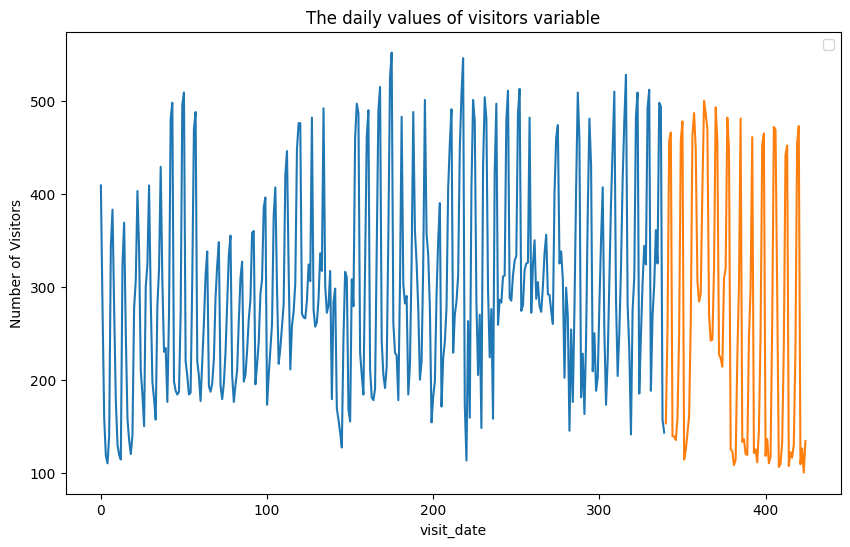

In [6]:
# Split the data into training and testing sets
train_percent = 0.8  # Use 80% of the data for training
split_index = int(len(merged_data) * train_percent)
train_data = visitor_data.iloc[:split_index]
test_data = visitor_data.iloc[split_index:]

# Convert the index (visit_date) to datetime
merged_data.index = pd.to_datetime(merged_data.index)

plt.figure(figsize=(10, 6))
plt.plot(train_data['visitors'])
plt.plot(test_data['visitors'])
plt.title('The daily values of visitors variable')
plt.xlabel('visit_date')
plt.ylabel('Number of Visitors')
plt.legend()
plt.show()

#### Feature Engineering

In [7]:
## flag in: 下雨or不下雨
## 减少features

# 1. Encoding Categorical Variables
df = pd.get_dummies(merged_data, columns=['day_of_week'])

# 2. Creating a binary feature for heavy rainfall
merged_data['heavy_rainfall'] = (merged_data['Daily Rainfall Total (mm)'] > 20).astype(int)

# 3. Categorizing temperature
merged_data['temperature_category'] = pd.cut(df['Mean Temperature (°C)'],
                                    bins=[-np.inf, 15, 25, np.inf],
                                    labels=['cold', 'mild', 'hot'])

# 4. Consolidating Holiday Flags
merged_data['is_holiday'] = merged_data[['holiday_flg_sg', 'holiday_flg_cn', 'holiday_flg_in']].max(axis=1)

# 5. Adding week of the year
merged_data['week_of_year'] = pd.to_datetime(merged_data['visit_date']).dt.isocalendar().week

# It's essential to transform these new categorical variables into a form suitable for modeling
merged_data = pd.get_dummies(merged_data, columns=['temperature_category'])

merged_data.head()

,day_of_week,visit_date,visitors,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),...,Max Wind Speed (km/h),holiday_flg_sg,holiday_flg_cn,holiday_flg_in,heavy_rainfall,is_holiday,week_of_year,temperature_category_cold,temperature_category_mild,temperature_category_hot
1970-01-01 00:00:00.000000000,Sunday,2023-01-01,409,0.0,0.0,0.0,0.0,27.8,32.0,25.8,...,27.0,1,1,1,0,1,52,0,0,1
1970-01-01 00:00:00.000000001,Monday,2023-01-02,276,4.0,3.0,3.2,3.4,27.5,33.4,24.7,...,25.6,1,1,1,0,1,1,0,0,1
1970-01-01 00:00:00.000000002,Tuesday,2023-01-03,158,5.8,5.6,5.8,5.8,27.0,32.8,24.5,...,22.4,0,0,0,0,0,1,0,0,1
1970-01-01 00:00:00.000000003,Wednesday,2023-01-04,118,0.0,0.0,0.0,0.0,27.1,30.1,25.1,...,32.0,0,0,0,0,0,1,0,0,1
1970-01-01 00:00:00.000000004,Thursday,2023-01-05,110,38.6,23.2,34.2,38.6,26.4,31.6,23.5,...,25.6,0,0,0,1,0,1,0,0,1


### ARIMA Model

1. Check for stationarity

In [8]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

check_stationarity(df['visitors'])

ADF Statistic: -4.540648893121901
p-value: 0.00016592835765189394
Series is stationary


2. Plotting ACF and PACF to determine order parameters of ARIMA Model (p,d,q)

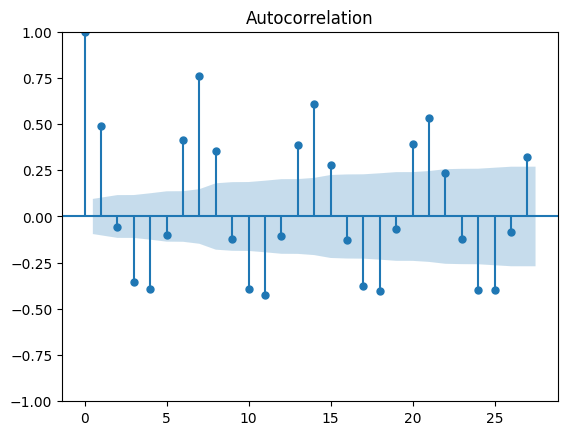

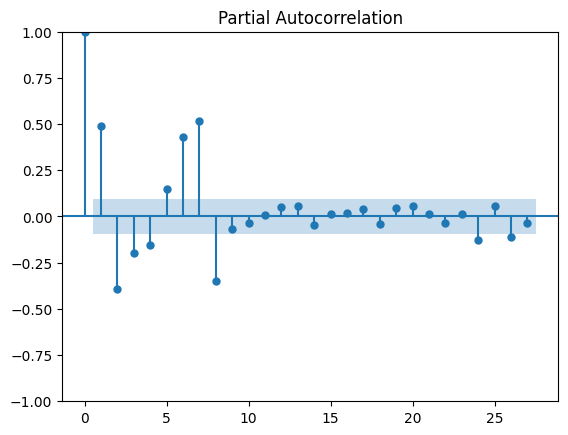

In [9]:
plot_acf(df['visitors'].dropna())
plot_pacf(df['visitors'].dropna())
plt.show()

ACF and PACF Plots: Use the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to determine the potential values for q and p, respectively.

ACF Plot for q: The ACF plot shows the correlation of the series with its lags. In general, you're looking for the point where the ACF plot crosses the upper confidence interval for the first time. This point suggests a good starting value for q.

PACF Plot for p: The PACF plot shows the partial correlation of the series with its lags. You're looking for the point where the PACF plot crosses the upper confidence interval for the first time. This point is a good starting value for p.

From above plot, we shall try q = 1 and p = 1.

3. Model fitting

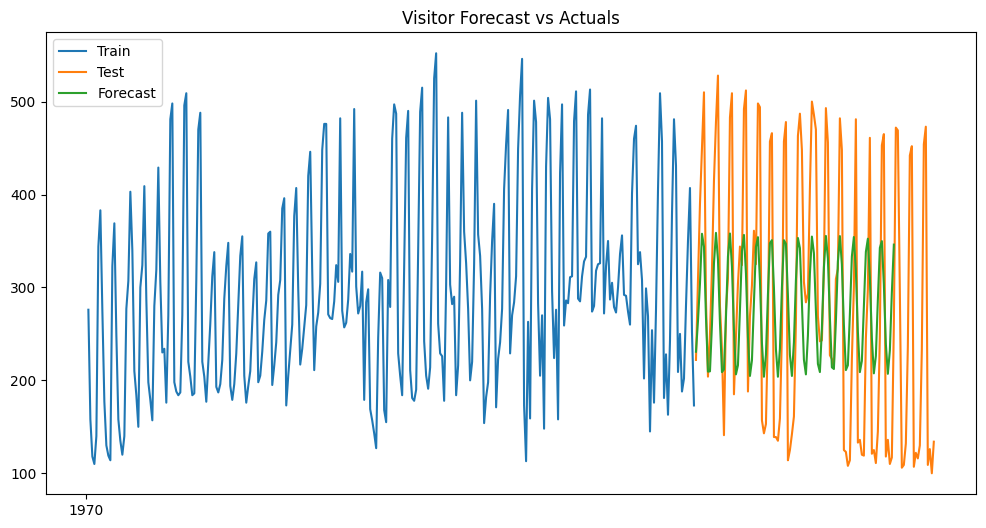

In [30]:
# Split data into train and test
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = ARIMA(train_data, order=(4,1,3))  # p, d, q to be chosen based on your ACF and PACF analysis
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=100)
forecast = pd.Series(forecast, index=test_data.index)

# Plotting the forecast against actual values
plt.figure(figsize=(12,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Forecast')
plt.title('Visitor Forecast vs Actuals')
plt.legend(loc='upper left')
plt.show()

4. Fine-tuning hyperparameters using Grid Search

In [24]:
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))

warnings.filterwarnings("ignore")  # ignore warnings from ARIMA fitting

best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        mod = ARIMA(df['visitors'], order=param)
        results = mod.fit()
        
        # Compare current model's AIC with the best so far
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:
        continue

print('Best ARIMA{} AIC={}'.format(best_pdq, best_aic))

Best ARIMA(4, 1, 3) AIC=4848.416966864049


In [12]:
# Evaluate model
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 75.89194339088861


#### LSTM

2024-04-08 20:07:58.967528: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-08 20:07:58.967551: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-08 20:07:58.967563: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-08 20:07:58.967819: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-08 20:07:58.967836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-04-08 20:08:00.725255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 - 6s - 1s/step - loss: 0.2122 - val_loss: 0.2079
Epoch 2/100
5/5 - 0s - 38ms/step - loss: 0.1497 - val_loss: 0.1356
Epoch 3/100
5/5 - 0s - 36ms/step - loss: 0.0960 - val_loss: 0.0750
Epoch 4/100
5/5 - 0s - 34ms/step - loss: 0.0675 - val_loss: 0.0518
Epoch 5/100
5/5 - 0s - 34ms/step - loss: 0.0677 - val_loss: 0.0519
Epoch 6/100
5/5 - 0s - 35ms/step - loss: 0.0652 - val_loss: 0.0483
Epoch 7/100
5/5 - 0s - 33ms/step - loss: 0.0570 - val_loss: 0.0520
Epoch 8/100
5/5 - 0s - 34ms/step - loss: 0.0547 - val_loss: 0.0539
Epoch 9/100
5/5 - 0s - 33ms/step - loss: 0.0514 - val_loss: 0.0483
Epoch 10/100
5/5 - 0s - 34ms/step - loss: 0.0488 - val_loss: 0.0435
Epoch 11/100
5/5 - 0s - 35ms/step - loss: 0.0465 - val_loss: 0.0409
Epoch 12/100
5/5 - 0s - 33ms/step - loss: 0.0439 - val_loss: 0.0399
Epoch 13/100
5/5 - 0s - 33ms/step - loss: 0.0407 - val_loss: 0.0394
Epoch 14/100
5/5 - 0s - 33ms/step - loss: 0.0346 - val_loss: 0.0382
Epoch 15/100
5/5 - 0s - 33ms/step - loss: 0.0310 - val_loss: 0.0368
Epo

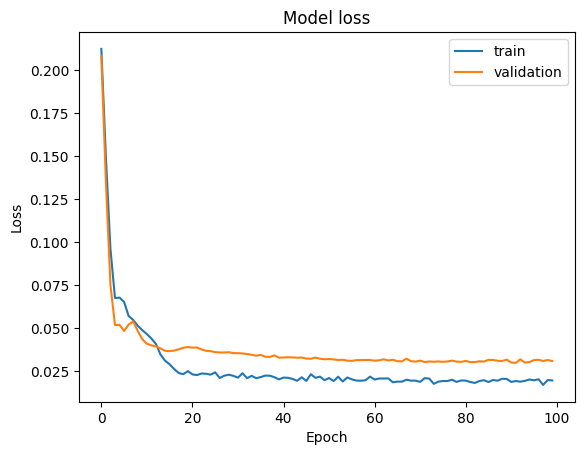

In [13]:
# Create lag features for visitors
for lag in range(1, 8):  # 7 days lag
    merged_data[f'visitors_lag_{lag}'] = merged_data['visitors'].shift(lag)

# Create rolling window features (7-day rolling mean and std deviation)
merged_data['rolling_mean_visitors'] = merged_data['visitors'].rolling(window=7).mean().shift(1)
merged_data['rolling_std_visitors'] = merged_data['visitors'].rolling(window=7).std().shift(1)

# Fill any NaN values that have been introduced by lag/rolling features
merged_data.fillna(method='bfill', inplace=True)

merged_data['year'] = merged_data['visit_date'].dt.year
merged_data['month'] = merged_data['visit_date'].dt.month
merged_data['day'] = merged_data['visit_date'].dt.day
lstm_data = merged_data.drop(['visit_date','day_of_week'], axis=1, inplace=False)
X = lstm_data.drop(['visitors'], axis=1)
y = lstm_data['visitors']
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1,1))
X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Select features and target
X = lstm_data.drop(['visitors'], axis=1)
y = lstm_data['visitors']

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1,1))

# Reshape for LSTM [samples, time steps, features]
X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Build the LSTM model with dropout
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=2)

# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Test RMSE: 67.469


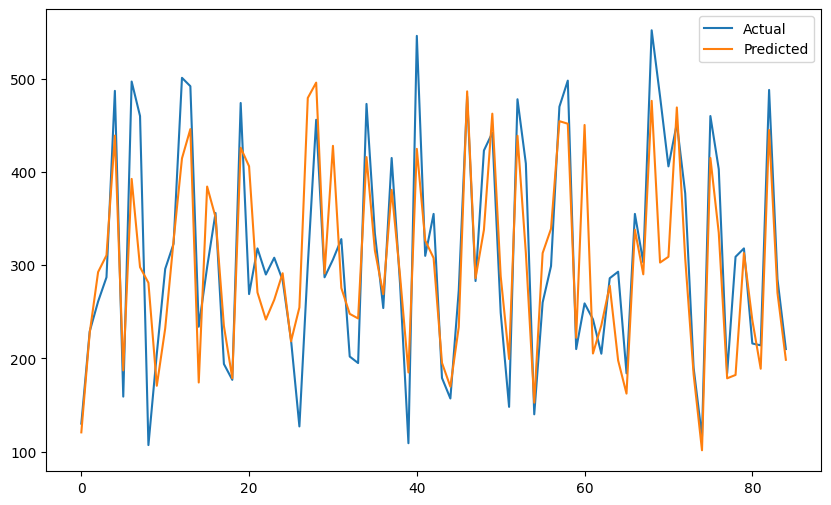

In [16]:
# Predict and inverse transform predictions
predictions = model.predict(X_test)
predictions_inv = scaler.inverse_transform(predictions)

# Inversely transform y_test for comparison
y_test_inv = scaler.inverse_transform(y_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
print(f'Test RMSE: {rmse:.3f}')

# Plot predictions against actual values
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.legend()
plt.show()

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=50, max_value=200, step=50),
                   return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units2', min_value=20, max_value=100, step=20), return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=10)])

best_model = tuner.get_best_models(num_models=1)[0]
loss = best_model.evaluate(X_test, y_test)